# Assignment 4: Gradient Descent

In [1]:
# enter your name and UFL email address
name = 'enter your name'
email = 'enter your email'

name = 'solution' # ###- 
email = 'solution' # ###- 

In [2]:
if name == 'enter your name' or email == 'enter your email':
    assert False, 'Enter your name & email first!'
else:
    print('Assignment 4 -- name: {}, email: {}\n'.format(name, email))
    
    # Load packages we need
    import sys
    import os
    import time

    import numpy as np
    import pandas as pd
    import sklearn

    from matplotlib import pyplot as plt
    plt.rcParams.update({'font.size': 16})

    # Let's check our software versions
    print('### Python version: ' + __import__('sys').version)
    print('### NumPy version: ' + np.__version__)
    print('### Scikit-learn version: ' + sklearn.__version__)
    print('------------')


    # load our packages / code
    sys.path.insert(1, '../common/')
    import utils
    import plots

Assignment 4 -- name: solution, email: solution

### Python version: 3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]
### NumPy version: 1.19.5
### Scikit-learn version: 0.24.0
------------


In [3]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

# deterministic seed for reproducibility
##rng = np.random.default_rng(seed)  # best practice but not fully implemented in scikit-learn
np.random.seed(seed)

prop_vec = [14, 3, 3]

## Part 1: Loading and Pre-processing Data

### For this assignment we'll load the Bike Sharing dataset (hourly)
### This dataset contains features of users bike sharing/rental on an hourly basis.
### The task is to predict how many users are sharing/renting a bike.

### Loading data

In [4]:
### Note: this dataset has missing values (artificially introduced), which you'll need to fill in before you can train a model
df = pd.read_csv('../data/bikesharehour.csv.gz', compression='gzip', header=0, na_values='?')

# Check that we loaded the data as expected
df_expected_shape = (17379, 15)

assert df.shape == df_expected_shape, 'Unexpected shape of df!'

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      16320 non-null  float64
 1   year        16231 non-null  float64
 2   month       16304 non-null  float64
 3   hour        16254 non-null  float64
 4   holiday     16277 non-null  float64
 5   weekday     16282 non-null  float64
 6   workingday  16297 non-null  float64
 7   weathersit  16324 non-null  float64
 8   temp        16242 non-null  float64
 9   atemp       16271 non-null  float64
 10  hum         16252 non-null  float64
 11  windspeed   16281 non-null  float64
 12  registered  16244 non-null  float64
 13  nsqrtc      16263 non-null  float64
 14  count       17379 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 2.0 MB


In [5]:
## what does the data look like?
df.head()

,season,year,month,hour,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,registered,nsqrtc,count
0,1.0,0.0,NaN,0.0,0.0,6.0,0.0,1.0,NaN,0.0,0.0,0.0,13.0,-5.0,16
1,1.0,0.0,NaN,1.0,0.0,6.0,0.0,1.0,NaN,0.0,0.0,0.0,32.0,-8.0,40
2,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,27.0,-7.0,32
3,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,-5.0,13
4,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1


### There are some NaNs which we'll have to impute!

In [6]:
# grab all the data as a numpy matrix
all_xy = df.to_numpy()

col_names = [c for c in df.columns]
features = col_names[:-1]
target = col_names[-1]

In [7]:
print('features: {} --- target: {}'.format(features, target))

features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'registered', 'nsqrtc'] --- target: count


In [8]:
# how many NaNs in each column?
np.sum(np.isnan(all_xy), axis=0)

array([1059, 1148, 1075, 1125, 1102, 1097, 1082, 1055, 1137, 1108, 1127,
       1098, 1135, 1116,    0])

### Observe: no NaNs in the target/value column
### About 1000+ NaNs in each feature

In [9]:
# split into x and y
all_x_nan = all_xy[:,:-1]
all_y = all_xy[:,-1]

### Let's impute the missing values!

In [10]:
from sklearn.impute import SimpleImputer

###* put your code here (~2-3 lines) *###
mf_imputer = SimpleImputer(missing_values=np.nan, strategy='median', copy=True)

all_x_mf = mf_imputer.fit_transform(all_x_nan)
all_x = all_x_mf

In [11]:
# check that the shape is correct
assert all_x.shape == (17379, 14)

# check that there are no more NaNs
assert np.sum(np.sum(np.isnan(all_x), axis=0)) == 0

### Rescale the features

In [12]:
# Before we start, we'll min-max normalize the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(copy=True)
scaler.fit(all_x) 

scaled_all_x = scaler.transform(all_x)

### Let's split the data

In [13]:
# split the data into train, test, val
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(scaled_all_x, all_y, prop_vec, shuffle=True, seed=seed)

# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((12166, 14), (12166,), (2607, 14), (2607,), (2606, 14), (2606,))

## [Task 1] (35 points) Batch Gradient Descent

### Let's train a linear regression model that we can use as a point of comparison

In [14]:
from sklearn.linear_model import LinearRegression

lrmodel = LinearRegression().fit(train_x, train_y)

### Let's implement batch gradient descent!

In [15]:
def batch_gradient_descent(X, y, gradient_fn, lr_schedule_fn, num_iter=1000, stop_fn = None, verbose=False):
    (n, m) = X.shape
    theta = np.random.uniform(low=-1.0, high=1.0, size=(X.shape[1],1)) # initialize uniformly at random in [-1, 1]
    
    for i in range(0, num_iter):
        eta = lr_schedule_fn(i) # learning rate
        
        gradient = gradient_fn(X, y, theta) # calculate gradient vector
        assert gradient.shape == theta.shape
        
        prev_theta = theta 
        
        # update theta (actual gradient descent step)
        theta = theta - eta * gradient
        
        # compute diff 
        diff = theta - prev_theta
        l2ndiff = np.linalg.norm(diff)
        
        if verbose and i % (num_iter/20) == 0:
            print('Iter {}, learning rate: {:.6f}, diff in theta (L2-norm): {:.6f}.'.format(i, eta, l2ndiff))
            
        if stop_fn is not None and stop_fn(diff):
            if verbose:
                print('Stop condition reached (iter {}).'.format(i))
            break
    
    return theta.reshape(-1,), i

### [Task 1a] (5 points) Define a constant learning rate schedule.

In [16]:
# this is a constant schedule, it should always return the learning rate eta (regardless of iteration)
def constant_lr_schedule(eta, iteration):
    ###* put your code here (~1 line) *###
    return eta

### [Task 1b] (20 points) Implement gradient_mse() which calculates the gradient vector of MSE

In [19]:
### For this you'll want to go back to the course slides (e.g., lecture 10 slide 7) or spend some time figuring out the gradient of MSE 
### (the loss) with respect to the parameters (i.e., theta which includes the weights vector w and bias b)
### Note: asserts are there to help you ensure that things have the right shape. 
### If you get shape errors when running your code, you should think about what shape each component of the gradient should have.
def gradient_mse(X, y, theta):
    (n, m) = X.shape
    
    y = y.reshape(-1,1)
    assert y.shape == (n,1)
    assert theta.shape == (m,1)
    
    ### Recall that the gradient of MSE is: 2/n X^T (θ X - y)   (note: θ = theta)
    ###* put your code here (~1-3 lines) *###
    
    # for this to work, we need the term θ X - y to have shape (n,1)
    # given the shapes of X (n,m) and theta (m,1), we need to multiply X by theta on the right
    res = np.dot(X, theta) - y

    return 2.0/n * np.dot(X.T, res)

### Now let's train the model (theta) using batch_gradient_descent()

In [20]:
# add a constant feature of 1 to each row to account for the bias term
X_with_b = np.c_[np.ones((train_x.shape[0],1)), train_x]

grad_fn = gradient_mse

# use a lambda to define the constant schedule with the learning rate baked in
learning_rate = 0.05
lr_sched_fn = lambda i: constant_lr_schedule(learning_rate, i)

# actually run the gradient descent and store the result in theta
theta, _ = batch_gradient_descent(X_with_b, train_y, grad_fn, lr_sched_fn, num_iter=50000, verbose=True)

Iter 0, learning rate: 0.050000, diff in theta (L2-norm): 36.157992.
Iter 2500, learning rate: 0.050000, diff in theta (L2-norm): 0.015673.
Iter 5000, learning rate: 0.050000, diff in theta (L2-norm): 0.000254.
Iter 7500, learning rate: 0.050000, diff in theta (L2-norm): 0.000080.
Iter 10000, learning rate: 0.050000, diff in theta (L2-norm): 0.000079.
Iter 12500, learning rate: 0.050000, diff in theta (L2-norm): 0.000077.
Iter 15000, learning rate: 0.050000, diff in theta (L2-norm): 0.000075.
Iter 17500, learning rate: 0.050000, diff in theta (L2-norm): 0.000074.
Iter 20000, learning rate: 0.050000, diff in theta (L2-norm): 0.000072.
Iter 22500, learning rate: 0.050000, diff in theta (L2-norm): 0.000071.
Iter 25000, learning rate: 0.050000, diff in theta (L2-norm): 0.000070.
Iter 27500, learning rate: 0.050000, diff in theta (L2-norm): 0.000068.
Iter 30000, learning rate: 0.050000, diff in theta (L2-norm): 0.000067.
Iter 32500, learning rate: 0.050000, diff in theta (L2-norm): 0.000065

### [Task 1c] (5 points) Extract the parameters (w, b) from theta, then compare them to the parameters of the linear regression model (lrmodel). 

In [21]:
# Print the weights and bias for both models
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print('Linear Regression model -- w: {}, b: {:.3f}'.format(lrmodel.coef_, lrmodel.intercept_))

### extract (w,b) from theta and print them
###* put your code here (~2 lines) *###
b = theta[0]
w = theta[1:]

print('Batch Gradient Descent model -- w: {}, b: {:.3f}'.format(w, b))

Linear Regression model -- w: [ 19.048  9.152 -10.044  37.807 -9.086  6.724 -34.405 -26.372  9.858
 -2.772 -9.309  20.558  1000.480 -12.950], b: 17.438
Batch Gradient Descent model -- w: [ 19.049  9.153 -10.044  37.809 -9.087  6.726 -34.407 -26.373  3.242
 -0.833 -9.309  20.557  1000.481 -12.957], b: 17.442


### [Task 1d] (5 points) What do you notice? Is it expected?

In [22]:
###* put your answer here *###
#
#
# We see that the parameters are very similar, not identical but very similar. 
# This is expected as the underlying model is the same (linear regression).
# Only the optimization procedure is different.
#

## [Task 2] (35 points) Implementing Stochastic Gradient Descent

### [Task 2a] (10 points) Fill in the implementation of SGD.

In [23]:
def stochastic_gradient_descent(X, y, gradient_fn, lr_schedule_fn, num_epochs=1000, stop_fn=None, verbose=False):
    (n, m) = X.shape
    theta = np.random.uniform(low=-1.0, high=1.0, size=(X.shape[1],1)) # initialize uniformly at random in [-1, 1]
    
    for i in range(0, num_epochs):
        prev_theta = theta

        # in each epoch go over the entire data
        for j in range(0, n):
            t = i*n+j
            eta = lr_schedule_fn(t)
            
            ### Pick a single example out of the training data (X, y) uniformly at random, that is: 
            ### the feature vector and corresponding target/label
            ### Call the feature vector 'xc' and the target/label 'yc'
            ###* put your code here (~2-3 lines) *###
            ridx = np.random.randint(n)
            xc = X[ridx,:]
            yc = y[ridx]
            
            assert xc.shape == (m,) and yc.shape == ()
            
            # calculate gradients
            gradient = gradient_fn(xc.reshape(1,-1), yc.reshape(-1,1), theta) 
            assert gradient.shape == theta.shape   
            
            # update theta (actual gradient descent step)
            theta = theta - eta * gradient

        # compute diff 
        diff = theta - prev_theta
        l2ndiff = np.linalg.norm(diff)

        if verbose and i % (num_epochs/20) == 0:
            print('Epoch {}, learning rate: {:.9f}, diff in theta (L2-norm): {:.6f}.'.format(i, eta, l2ndiff))

        if stop_fn is not None and stop_fn(diff):
            if verbose:
                print('Stop condition reached (iter {}).'.format(i))
            break
    
    return theta.reshape(-1,), i

### Let's train the model for 250 epochs with a constant learning schedule.

In [24]:
# use a lambda to define the constant schedule with the learning rate baked in
learning_rate = 0.05
lr_sched_fn = lambda i: constant_lr_schedule(learning_rate, i)

theta, _ = stochastic_gradient_descent(X_with_b, train_y, gradient_mse, lr_sched_fn, num_epochs=250, verbose=True)

Epoch 0, learning rate: 0.050000000, diff in theta (L2-norm): 1013.477021.
Epoch 25, learning rate: 0.050000000, diff in theta (L2-norm): 108.732698.
Epoch 50, learning rate: 0.050000000, diff in theta (L2-norm): 69.817389.
Epoch 75, learning rate: 0.050000000, diff in theta (L2-norm): 61.468455.
Epoch 100, learning rate: 0.050000000, diff in theta (L2-norm): 80.031508.
Epoch 125, learning rate: 0.050000000, diff in theta (L2-norm): 54.006748.
Epoch 150, learning rate: 0.050000000, diff in theta (L2-norm): 85.679083.
Epoch 175, learning rate: 0.050000000, diff in theta (L2-norm): 58.227511.
Epoch 200, learning rate: 0.050000000, diff in theta (L2-norm): 78.481088.
Epoch 225, learning rate: 0.050000000, diff in theta (L2-norm): 108.616293.


In [25]:
b = theta[0]
w = theta[1:]

# Print the weights and bias for both models
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print('Linear Regression model -- w: {}, b: {:.3f}'.format(lrmodel.coef_, lrmodel.intercept_))
print('Stochastic Gradient Descent model -- w: {}, b: {:.3f}'.format(w, b))

Linear Regression model -- w: [ 19.048  9.152 -10.044  37.807 -9.086  6.724 -34.405 -26.372  9.858
 -2.772 -9.309  20.558  1000.480 -12.950], b: 17.438
Stochastic Gradient Descent model -- w: [ 20.069  3.310 -12.118  37.742  0.206 -11.093 -34.761 -50.529  18.165
  0.477 -8.298  17.320  1015.943 -5.579], b: 40.086


### [Task 2b] (10 points) Provide an explanation as to what is happening? Is the process converging? Explain why.

In [26]:
# Provide an explanation as to what is happening? Is the process converging? Explain why.
###* put your answer here *###
#
#
# The process does not seem to be converging. 
# This is because of the stochastic nature of the process combined with the fact that the learning rate is too high
# If we introduce a non-constant learning schedule, we could decrease the learning rate over time.
#
# It's important to note that it is not necessarily the case that the model will have bad performance. 
# In fact, the weight of the most important feature is similar to that of lrmodel. 
# But the point is that the parameters vary wildly from one epoch to the next (even after 250 epochs of training).
#

### [Task 2c] (5 points) Train the model with a simple learning schedule that decreases the learning rate over time.

In [27]:
# use a lambda to define a simple schedule that decreases the learning rate over time
learning_rate = 0.05
lr_sched_fn = lambda t: learning_rate / (1 + np.sqrt(t))

# actually run the stochastic_gradient_descent for 250 epochs and store the result in 'theta'
# make sure to use the simple learning schedule defined above (lr_sched_fn). Also set verbose=True
###* put your code here (~1 line) *###
theta, _ = stochastic_gradient_descent(X_with_b, train_y, gradient_mse, lr_sched_fn, num_epochs=250, verbose=True)


Epoch 0, learning rate: 0.000449256, diff in theta (L2-norm): 425.381763.
Epoch 25, learning rate: 0.000088744, diff in theta (L2-norm): 5.112551.
Epoch 50, learning rate: 0.000063396, diff in theta (L2-norm): 1.771860.
Epoch 75, learning rate: 0.000051944, diff in theta (L2-norm): 1.162849.
Epoch 100, learning rate: 0.000045065, diff in theta (L2-norm): 0.600628.
Epoch 125, learning rate: 0.000040352, diff in theta (L2-norm): 1.013407.
Epoch 150, learning rate: 0.000036863, diff in theta (L2-norm): 0.662578.
Epoch 175, learning rate: 0.000034146, diff in theta (L2-norm): 0.407062.
Epoch 200, learning rate: 0.000031954, diff in theta (L2-norm): 0.574088.
Epoch 225, learning rate: 0.000030136, diff in theta (L2-norm): 0.303901.


In [28]:
b = theta[0]
w = theta[1:]

# Print the weights and bias for both models
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print('Linear Regression model -- w: {}, b: {:.3f}'.format(lrmodel.coef_, lrmodel.intercept_))
print('Stochastic Gradient Descent model -- w: {}, b: {:.3f}'.format(w, b))

Linear Regression model -- w: [ 19.048  9.152 -10.044  37.807 -9.086  6.724 -34.405 -26.372  9.858
 -2.772 -9.309  20.558  1000.480 -12.950], b: 17.438
Stochastic Gradient Descent model -- w: [ 19.305  9.667 -9.834  37.811 -9.173  6.625 -34.309 -26.351  0.003 -1.335
 -9.081  21.736  999.294 -12.957], b: 17.384


### [Task 2d] (10 points) Show that the model has similar performance as the linear regression model (lrmodel). For this, show the coefficient of determination, the RMSE, and the MedAE for both on the training and validation data.

In [29]:
# given model parameters 'theta' and a feature matrix 'x', this will return predictions
def predict_theta(theta, x):
    b = theta[0]
    w = theta[1:]
    
    assert w.shape[0] == x.shape[1]
    
    return np.dot(w, x.T) + b
    
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error

### You can implement this however you like. A simple way is to define a function to calculate and print 
### the scores and then call it for each model and dataset (train or val). For example, this function could have 
### the following signature: 'def print_scores(desc, true_y, pred_y):'
### Hint: use predict_theta() for getting predictions from the model trained with SGD.
###* put your code here (~10 lines) *###
def print_scores(desc, true_y, pred_y):
    r2 = r2_score(true_y, pred_y)
    rmse = mean_squared_error(true_y, pred_y, squared=False)
    medae = median_absolute_error(true_y, pred_y)
    
    print('[{}] R^2: {:.2f}, RMSE: {:.2f}, MedAE: {:.2f}'.format(desc, r2, rmse, medae))
    
print_scores('LR Train', train_y, lrmodel.predict(train_x))
print_scores('LR Val', val_y, lrmodel.predict(val_x))
print()
print_scores('SGD Train', train_y, predict_theta(theta, train_x))
print_scores('SGD Val', val_y, predict_theta(theta, val_x))

[LR Train] R^2: 0.89, RMSE: 58.95, MedAE: 21.18
[LR Val] R^2: 0.88, RMSE: 61.91, MedAE: 21.18

[SGD Train] R^2: 0.89, RMSE: 58.95, MedAE: 21.24
[SGD Val] R^2: 0.88, RMSE: 61.91, MedAE: 21.29


## [Task 3] (20 points) Mini-Batch Stochastic Gradient Descent

### [Task 3a] (5 points) Complete the implementation of mini_batch_sgd to include a callback after each epoch. This callback will be useful to obtain information during the optimization process. If the callback function is defined, your code should call it with the proper arguments.

In [30]:
def mini_batch_sgd(X, y, gradient_fn, lr_schedule_fn, num_epochs=1000, batch_size=100, callback_fn=None, stop_fn=None, verbose=False):
    
    (n, m) = X.shape
    theta = np.random.uniform(low=-1.0, high=1.0, size=(X.shape[1],1)) # initialize uniformly at random in [-1, 1]
    
    batch_size = np.minimum(n, batch_size)
    
    for epoch in range(0, num_epochs):
        prev_theta = theta

        # shuffle the data
        pi = np.random.permutation(n)
        Xshuf = X[pi,:]
        yshuf = y[pi]
        for batch_start in range(0, n, batch_size):
            
            batch_idx = batch_start/batch_size
            bsidx = batch_start
            beidx = np.minimum(n, bsidx + batch_size)
            Xmb = Xshuf[bsidx:beidx,:]
            ymb = yshuf[bsidx:beidx]
            
            eta = lr_schedule_fn(epoch*n + bsidx)
            
            # grab gradient vector
            gradient = gradient_fn(Xmb, ymb, theta)
            assert gradient.shape == theta.shape  
            
            # update theta (actual gradient descent step)
            theta = theta - eta * gradient
            
        
        ### If callback_fn is defined (not None), call it and pass it the current epoch and current set of parameters
        ###* put your code here (~2 lines) *###
        if callback_fn is not None:
            callback_fn(epoch, theta)

        # compute diff 
        diff = theta - prev_theta
        l2ndiff = np.linalg.norm(diff)

        if verbose and epoch % (num_epochs/20) == 0:
            print('Epoch {}, learning rate: {:.9f}, diff in theta (L2-norm): {:.6f}.'.format(epoch, eta, l2ndiff))

        if stop_fn is not None and stop_fn(diff):
            if verbose:
                print('Stop condition reached (iter {}).'.format(i))
            break
            
    return theta.reshape(-1,), epoch

### [Task 3b] (5 points) Fill in the implementation of the callback function to save the RMSE.

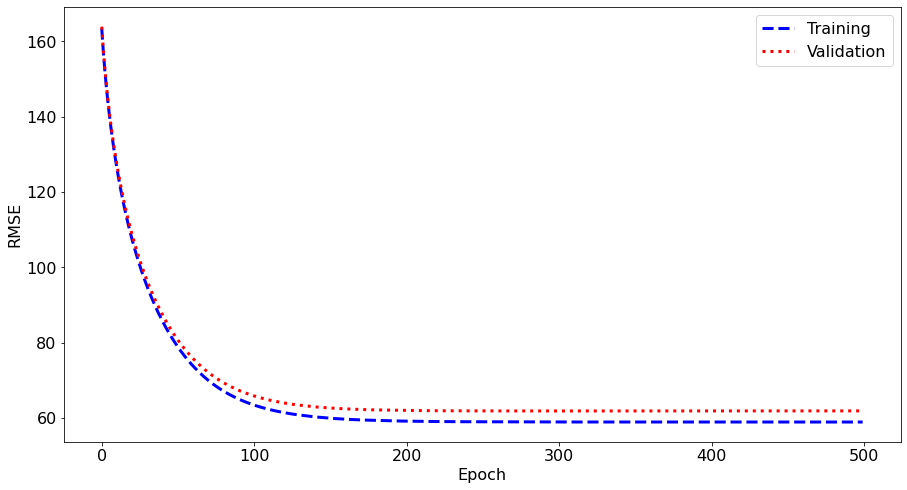

In [31]:
# let's use the following plotting function to explore our loss during gradient descent
def plot_process_data(proc_data, ylabel, xlim=None, ylim=None):
    plt.figure(figsize=(15,8))

    plt.xlabel('Epoch')
    plt.ylabel(ylabel)

    plt.plot(np.arange(proc_data.shape[0]), proc_data[:,0], 'b--', linewidth=3, label='Training')
    plt.plot(np.arange(proc_data.shape[0]), proc_data[:,1], 'r:', linewidth=3, label='Validation')

    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)    
    plt.show()


# This will be our callback function. 
# After each epoch, this function gets called so we can check on the progress of gradient descent
# We'll save the RMSE for both train and val in the 'rmse' array so we can plot it later
def rmse_per_epoch(epoch, theta, rmse, train_x, train_y, val_x, val_y):
    theta = theta.reshape(-1,)
    pred_y = predict_theta(theta, train_x)
    
    ### compute the RMSE on the training data, store the result in 'rmse[epoch, 0]'
    ###* put your code here (~2 lines) *###
    train_rmse = mean_squared_error(train_y, pred_y, squared=False)
    rmse[epoch, 0] = train_rmse
    
    pred_y = predict_theta(theta, val_x)
    
    ### compute the RMSE on the validation data, store the result in 'rmse[epoch, 1]'
    ###* put your code here (~2 lines) *###
    val_rmse = mean_squared_error(val_y, pred_y, squared=False)
    rmse[epoch, 1] = val_rmse


# params for gradient descent
num_epochs = 500
bsz = 100

# define our array to store the rmse_data. One row per epoch, column 0 will be train, column 1 will be val.
rmse_data = np.zeros((num_epochs,2))

# define the callback function
ecbfn = lambda i, t : rmse_per_epoch(i, t, rmse_data, train_x, train_y, val_x, val_y)

# use a lambda to define a simple schedule that decreases the learning rate slowly over time
learning_rate = 0.05
lr_sched_fn = lambda t: learning_rate / (1 + np.log(1 + t)) 

theta, _ = mini_batch_sgd(X_with_b, train_y, grad_fn, lr_sched_fn, 
                          num_epochs=num_epochs, batch_size=bsz, callback_fn=ecbfn, verbose=False)

# do the actual plotting
plot_process_data(rmse_data, 'RMSE')

### [Task 3c] (5 points) Does the process converge? Should the number of epochs be increased? What about the learning rate?

In [32]:
###* put your answer here *###
#
#
# The process does converge. Looking at the two curves, it seems unlikely that more epochs would help. 
# The learning rate could be tweaked but it seems fine given the performance achieved
#

### [Task 3d] (5 points) What do you conclude? Is it worth training a linear regression model this way?

In [33]:
###* put your answer here *###
#
#
# It would be easier to just use the Normal Equation to train the model.
# But this works...
#

## [Task 4] (10 points) Use SGDRegressor to train a similar model to what you did in Task 3. Show that the performance of both models is comparable (show R^2, RMSE, MedAE for both train and val). 

In [34]:
from sklearn.linear_model import SGDRegressor

### Tip: if you defined a print_scores() method for Task 2d, you can reuse it here!
###* put your code here (~5 lines) *###
sgdregressor = SGDRegressor().fit(train_x, train_y)

print_scores('SGDReg Train', train_y, sgdregressor.predict(train_x))
print_scores('SGDReg Val', val_y, sgdregressor.predict(val_x))
print()
print_scores('SGD (Manual) Train', train_y, predict_theta(theta, train_x))
print_scores('SGD (Manual) Val', val_y, predict_theta(theta, val_x))

[SGDReg Train] R^2: 0.89, RMSE: 58.97, MedAE: 21.46
[SGDReg Val] R^2: 0.88, RMSE: 61.91, MedAE: 21.55

[SGD (Manual) Train] R^2: 0.89, RMSE: 58.95, MedAE: 21.23
[SGD (Manual) Val] R^2: 0.88, RMSE: 61.91, MedAE: 21.31


## [CIS6930 Additional Task -- Task 5] (25 points): Ridge Regression with Mini-batch SGD

### In this task, you will implement ridge regression using mini-batch SGD as defined in Task 3. 
### The main task is to derive the gradient vector for Ridge Regression (L2 regularization with MSE as loss).

### [Task 5a] (15 points) Implement the gradient_mse_ridge() function.

In [36]:
def gradient_mse_ridge(X, y, theta, lmbda):
    (n, m) = X.shape
    
    y = y.reshape(-1,1)
    assert y.shape == (n,1)
    assert theta.shape == (m,1)
    
    ### Figure out the gradient for ridge regression and implement this function 
    ### (You can refer to the course slides: lecture 5 on linear models, slide 12.)
    ### Note 1: use 'lmbda' (lambda) -- the regularization hyperparameter.
    ### Note 2: normally we do not regularize the bias b, but if you cannot avoid it is acceptable to regularize it for this task.
    ###* put your code here (~1-3 lines) *###  
    res = y - np.dot(X, theta)

    # the "trick" here to avoid regularizing the bias is just set to use zeros to pad the array to the correct length
    # and then use theta[1:] so we take only the weights (without including the bias)
    return - 2.0/n * np.dot(X.T, res) + 2*lmbda * np.r_[np.zeros((1,1)), theta[1:]]

### Let's put some code to do the mini-batch sgd ridge regression training.

In [38]:
def do_mbsgd_ridge(lmbda):
    num_epochs = 1000
    bsz = 100

    rmse_data = np.zeros((num_epochs,2))

    # define the callback function
    ecbfn = lambda i, t : rmse_per_epoch(i, t, rmse_data, train_x, train_y, val_x, val_y)

    # use a lambda to define a simple schedule that decreases the learning rate over time
    learning_rate = 0.05
    lr_sched_fn = lambda t: learning_rate / (1 + np.log(1 + t))

    # bake in lambda into the gradient fn
    grad_fn = lambda X, y, thet : gradient_mse_ridge(X, y, thet, lmbda)

    theta, _ = mini_batch_sgd(X_with_b, train_y, grad_fn, lr_sched_fn, 
                              num_epochs=num_epochs, batch_size=bsz, callback_fn=ecbfn, verbose=False)

    # do the actual plotting
    plot_process_data(rmse_data, 'RMSE')

    ### if you have defined print_scores above, you can uncomment the following lines.
    print_scores('SGD (Manual) Train', train_y, predict_theta(theta, train_x))
    print_scores('SGD (Manual) Val', val_y, predict_theta(theta, val_x))
    
    return theta

### [Task 5b] (5 points) In theory, what is the effect of L2 regularization on the weights vector?

In [39]:
###* put your answer here *###
#
#
# It decreases the weights such that there are less extreme values in the weights (makes the vector look gaussian).
# In other words, it shrinks the norm of the weights vector.
#

### [Task 5c] (5 points) Run mini-batch SGD for Ridge regression using whatever value of lambda you think is appropriate. Make sure that the process stills converges and that you end up with a model with a comparable performance to the ones you trained in previous tasks (but that still shows some effect from L2 regularization). Show the effect of regularization.

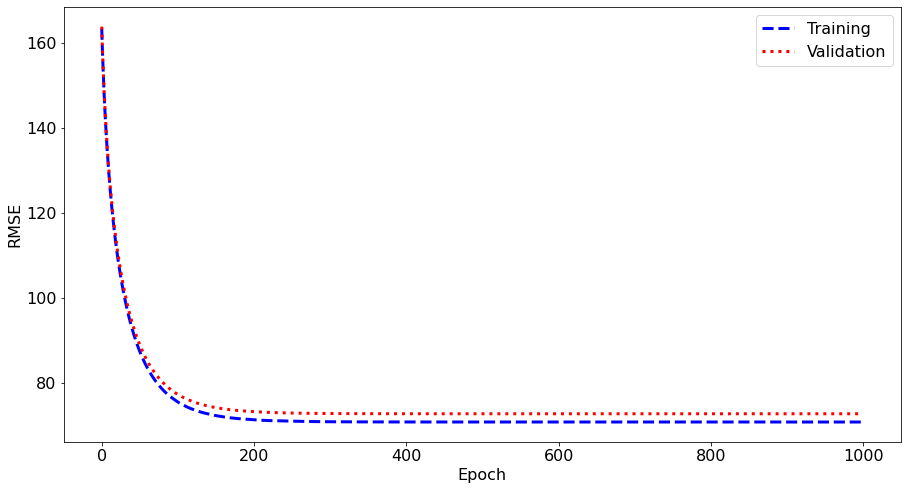

[SGD (Manual) Train] R^2: 0.85, RMSE: 70.77, MedAE: 35.21
[SGD (Manual) Val] R^2: 0.84, RMSE: 72.71, MedAE: 35.55
Linear Regression model -- w: [ 19.048  9.152 -10.044  37.807 -9.086  6.724 -34.405 -26.372  9.858
 -2.772 -9.309  20.558  1000.480 -12.950], b: 17.438
Mini-batch SGD Ridge -- w: [ 35.392  28.793 -5.216  83.546 -8.932  7.040 -20.999 -38.893  0.098
 -0.299 -13.101  31.244  730.639 -11.840], b: 8.925

Linear Regression: ||w||_2: 1002.86
Mini-batch SGD Ridge (lambda=0.008): ||w||_2: 739.12


In [40]:
###* put your code here (~1 line) to set the value of lambda *###
lmbda = 0.008


theta = do_mbsgd_ridge(lmbda)

b = theta[0]
w = theta[1:]

print('Linear Regression model -- w: {}, b: {:.3f}'.format(lrmodel.coef_, lrmodel.intercept_))
print('Mini-batch SGD Ridge -- w: {}, b: {:.3f}\n'.format(w, b))


###* put your code/answer here *###
#
# We can see from printing the norm of the weights that the weights are less extreme than with ridge regression.
# Linear Regression: ||w||_2: 1002.86
# Mini-batch SGD Ridge (lambda=0.008): ||w||_2: 739.12
#
print('Linear Regression: ||w||_2: {:.2f}'.format(np.linalg.norm(lrmodel.coef_)))
print('Mini-batch SGD Ridge (lambda={:.3f}): ||w||_2: {:.2f}'.format(lmbda, np.linalg.norm(w)))